# Group 10 - Milestone 3 Notebook
Shristi Pandey, James May, Zachary Werkhoven, Guilherme Braz


**Import libraries**

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
from ADNI_utilities import define_terms, describe_meta_data, paths_with_ext, append_meta_cols

## Raw Data Aggregation and Cleaning

The code and thought process behind the aggregation and cleaning of the ADNI raw data files is documented in great deal in the following notebooks on the [project respository](https://github.com/jamesm-vt/cs109a_adni): `biomarker_EDA.ipynb`, `diagnosis_EDA.ipynb`, `medical_history.ipynb`, `neuropsych_scores.ipynb`, `rawdata_grouping.ipynb`, and `sub_characteristics.ipynb`.

The resulting per patient data set can be in `patient_firstidx_merge.csv`

## Preliminary Modeling of the Imputed Data

The goal of this section is to perform some simple modeling on the imputed data set and identify the most important features for prediction. The data includes features with well-known links to Alzheimer's disease. If our data cleaning, imputation, and pre-processing has been done correctly, we should be able to identify these features such as **Amyloid Beta** and **Tau** protein measurements as significant predictors.

**Import Imputed Data**

In [2]:
# read in imputed data from file
imp_df = pd.read_csv("../data/Per_Patient/pat_merge_imputed_lasso_ada.csv")
imp_df.head()

,RID,AGE,PTEDUCAT,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,...,NXOTHER_2.0,DXMPTR5_1.0,NXFINGER_2.0,MOMAD_1.0,MOMAD_2.0,NXMOTOR_2.0,NXTENDON_2.0,NXVISUAL_2.0,NXHEEL_2.0,NXGAIT_2.0
0,2,0.537838,0.7500,0.667996,0.120293,0.719561,0.176637,0.144414,0.00,0.250059,...,0,1,0,0,0,0,0,0,0,0
1,3,0.727027,0.8750,0.386992,0.298280,0.361000,0.130902,0.132411,0.45,0.515585,...,0,1,0,0,0,0,0,0,0,0
2,4,0.354054,0.3750,0.455381,0.039562,0.867333,0.059918,0.047232,0.10,0.335833,...,0,1,0,0,0,0,0,0,0,0
3,5,0.521622,0.7500,0.595319,0.748069,0.231533,0.210656,0.227054,0.00,0.203187,...,0,1,0,0,0,0,0,0,0,0
4,6,0.702703,0.5625,0.413852,0.287194,0.603774,0.174573,0.178761,0.05,0.437544,...,0,1,0,0,0,0,1,0,0,0


**Split the data**

Since we have multiple potential response variables in our data, we should separate the predictors and the response variables into different data frames.

In [3]:
# define response columns
resp_set = ["DX_BASE","DX_FINAL","DX_CHANGE","DXCOMB","DX_bl"]
col_set = imp_df.columns.tolist()
is_resp = [any([resp in col for resp in resp_set]) for col in col_set]
resp_cols = imp_df.columns[is_resp]

# print response columns
print("Response columns:\n{}".format(resp_cols))

Response columns:
Index(['DX_BASE_2.0', 'DX_BASE_3.0', 'DXCOMB_2.0', 'DXCOMB_3.0',
       'DX_FINAL_2.0', 'DX_FINAL_3.0', 'DX_CHANGE_2.0', 'DX_CHANGE_4.0',
       'DX_CHANGE_5.0', 'DX_CHANGE_6.0', 'DX_CHANGE_7.0', 'DX_CHANGE_8.0',
       'DX_CHANGE_9.0', 'DX_bl_CN', 'DX_bl_MCI'],
      dtype='object')


As we can see from the list above, the response variables have been one-hot-encoded. We can reverse engineer the original classifications to pass in as the response vector for our models.

In [4]:
# iterate of response prefixes
resp_data = []
for resp in resp_set:
    
    # get subset of columns corresponding to currest prefix
    is_subset = [resp in col for col in col_set]
    subset_cols = imp_df.columns[is_subset]
    
    # convert train data to column index of true value
    tmp = np.argmax(imp_df[subset_cols].values,1)+1
    tmp[~imp_df[subset_cols].values.any(1)] = 0
    resp_data.append(tmp)

In [5]:
# drop one-hot response vars and add new features
imp_df = imp_df.drop(columns=resp_cols, axis=1)
for col, data in zip(resp_set, resp_data):
    imp_df[col] = pd.Series(np.array(data), index=imp_df.index)

With the categorical features engineered, we can split the data into train and test sets.

In [6]:
# divide the data into train and test sets
train_df, test_df = train_test_split(imp_df, test_size=0.2, shuffle=True)

# define new dataframe with response vars
y_train = train_df[resp_set]
x_train = train_df.drop(columns=resp_set, axis=1)
y_test = test_df[resp_set]
x_test = test_df.drop(columns=resp_set, axis=1)

## Logistic Regression

To train a model, we'll need to select a response variable from the set of:
- baseline diagnosis `DX_BASE`
- ADNI merge baseline diagnosis `DX_bl`
- final diagnosis `DX_FINAL`
- change in diagnosis from baseline to final `DX_CHANGE`

If we want to develop a model to predict ultimate diagnosis based on baseline measures, it makes sense to choose `DX_FINAL` as the response variable.

In [15]:
# define and fit logistic regression model
resp_var = 'DX_FINAL'
logit = LogisticRegressionCV(Cs=10,cv=3, solver='newton-cg', multi_class='multinomial', max_iter=100)
logit = logit.fit(x_train.values, y_train[resp_var].values)

C:\Users\winsl0w\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\winsl0w\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\winsl0w\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\winsl0w\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\winsl0w\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iteration

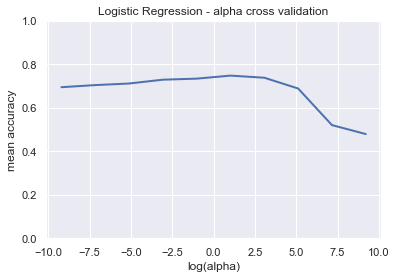

In [16]:
# plot cv accuracy as a function of alpha
plt.plot(np.log(1/logit.Cs_), logit.scores_[0].mean(0), lw=2)
plt.ylim(0,1)
plt.xlabel("log(alpha)")
plt.ylabel("mean accuracy")
plt.title("Logistic Regression - alpha cross validation");

From the plot above we can see the optimal value for our regularization parameter is somewhere between 0-100.

In [ ]:
# report test and train accuracy
print("Train accuracy = {0:.3f}".format(logit.score(x_train.values, y_train[resp_var].values)))
print("Test accuracy = {0:.3f}".format(logit.score(x_test.values, y_test[resp_var].values)))

The performancy of the model is significantly worse on the test data, suggesting that the model is likely overfit. Many of the coefficients are likely to be very close to zero. To get some sense of the coefficients of our models, we can start by plotting the log histogram of our coefficient magnitudes to help separate the values.

In [ ]:
# plot log histogram
plt.hist(np.log(np.abs(logit.coef_.flatten())))
plt.ylabel("count")
plt.xlabel("log(coefficient magnitude)");

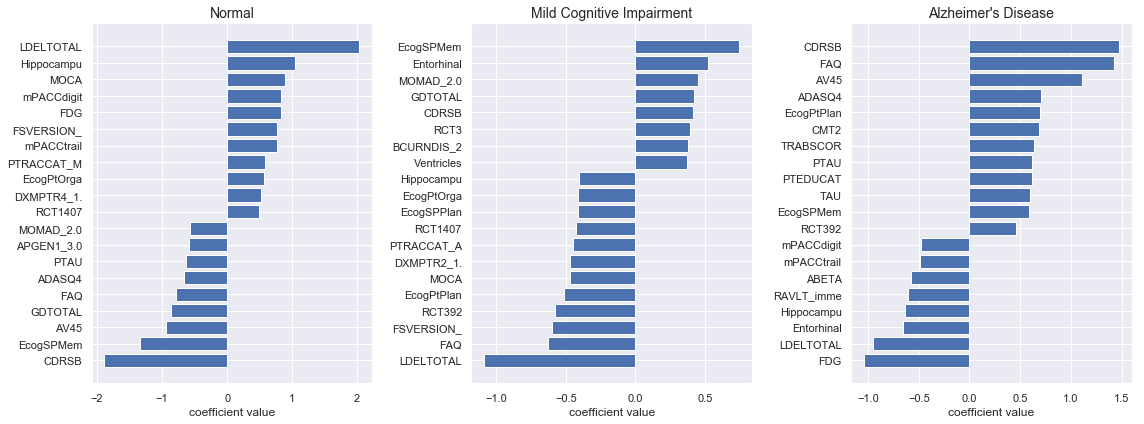

In [9]:
# plot top coefficients (by magnitude) for each model
f, ax = plt.subplots(1,3, figsize=(16,6))
coef_mag = np.abs(logit.coef_)
class_names = ["Normal","Mild Cognitive Impairment","Alzheimer's Disease"]

for i in range(len(ax)):
    
    # get indices of top parameters
    coef_idx = np.argsort(coef_mag[i,:])[-20:]
    coef_idx = coef_idx[np.argsort(logit.coef_[i,coef_idx])]
    
    # create horizontal bar plot
    ax[i].barh(np.arange(len(coef_idx)), logit.coef_[i,coef_idx], align='center', color='b')
    ax[i].set_yticks(np.arange(len(coef_idx)))
    y_labels = [col[:10] for col in x_train.columns[coef_idx].tolist()]
    ax[i].set_yticklabels(y_labels)
    ax[i].set_xlabel('coefficient value')
    ax[i].set_title(class_names[i], FontSize=14)
    
plt.tight_layout()

From the coefficient values above, we can see that many of the model coefficients match our expectations. For example, Tau, pTau, and the clinical dementia rating are all significantly positively predictive of Alzheimer's disease. However, there are some confusing results as well that will warrant further investigation. For example, Amyloid Beta levels in the cerebrospinal fluid are negatively predictive of Alzheimer's, which does not match our expectation.

## Random Forest Classifier

Given that the logistic regression model above was overfit, one simple thing to try is an ensemble classifier such as random forest that will offer the low model variance advantage of bagging. Let's try it out and see if the performance on the test set improves.

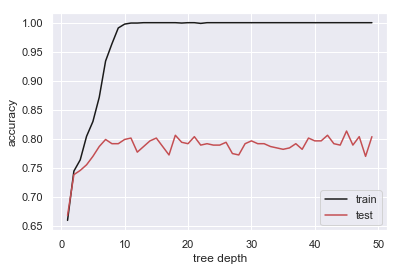

In [12]:
# define and fit logistic regression model
from sklearn.ensemble import RandomForestClassifier
resp_var = 'DX_FINAL'
depths = np.arange(1,50,1)
train_acc = np.empty(depths.shape[0])
test_acc = np.empty(depths.shape[0])

for i, depth in enumerate(depths):
    
    # train temp model
    rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=depth)
    rfc = rfc.fit(x_train.values, y_train[resp_var].values)
    train_acc[i] = rfc.score(x_train.values, y_train[resp_var].values)
    test_acc[i] = rfc.score(x_test.values, y_test[resp_var].values)
    
plt.plot(depths, train_acc, color='k', label="train")
plt.plot(depths, test_acc, color='r', label="test");
plt.xlabel("tree depth")
plt.ylabel("accuracy")
plt.legend();

In [13]:
# define tree model
rand_forest = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=6)
rand_forest = rand_forest.fit(x_train.values, y_train[resp_var].values)

In [14]:
# report test and train accuracy
print("Train accuracy = {0:.3f}".format(rand_forest.score(x_train.values, y_train[resp_var].values)))
print("Test accuracy = {0:.3f}".format(rand_forest.score(x_test.values, y_test[resp_var].values)))

Train accuracy = 0.874
Test accuracy = 0.787
